# Final Project Multi LLM debate 
**by Leander Streun , Linus Krause**

## Import and base settings

In [2]:
import csv
import pandas as pd
import pickle
import numpy as np
import os 
import openai
import re
import time
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter

openai.api_key = "C0VybV5RvUylKQtuOdEB"

openai.api_base = "http://91.107.239.71:80" 

model_name="gpt-3.5-turbo-0125"

topics = ['climate_change', 'gun_control', 'taxation', 'afghanistan_war', 'education', 'technology_security', 'speech', 'markets', 'societal_change', 'international_cooperation', 'basic_income']


In [2]:
base_prompts = pd.read_csv("data/base_prompts.csv", sep = ";")

In [32]:
base_prompts

,Topic,Stance1,Stance2,Names
0,Climate change,You are a forward-thinking innovator who firml...,You are a passionate advocate for addressing c...,pro_techno / post_growth
1,Gun control,You are a staunch advocate for individual libe...,You are a staunch advocate for strict gun cont...,pro_guns / anti_guns
2,Taxation,"You advocate for a low-tax environment, both f...",You advocate for a progressive approach to tax...,high_tax / low_tax
3,US approach to Afghanistan war,You are a staunch advocate for the continued p...,You advocate for a policy of disengagement and...,enforce_stability / leave_to_people
4,Education private vs public,You are an advocate of free-market principles ...,You are a staunch advocate for the democratiza...,private_ed / public_ed
5,Technology & Security,You are a staunch advocate for leveraging tech...,You are a staunch advocate for individual priv...,nat_security / indiv_privacy
6,Control of Speech,You advocate for the regulation of speech by g...,You are a staunch advocate for unconditional f...,control_speech / free_speech
7,Economic markets,You are a staunch advocate for laissez-faire e...,You are a staunch advocate for regulatory cont...,free_market / controlled_market
8,Conservative vs liberal societal change,You are a staunch advocate of traditional valu...,You are a fervent advocate for progressive soc...,traditional_stable / progressive_change
9,Problem Solving and international cooperation,You are a passionate advocate of globalization...,You are a proponent of a nation-centered appro...,globalist / nationalist


In [5]:
def create_system_prompt(belief_system, topic, debater, opposition):
    """
    This function combines our system prompt with rules about the debate and the belief system.
    """
    system_prompt = f"""The task and setting: 
    In the following, you will participate in a debate about a given topic. The debate will consist of 3 rounds, one starting round and two responsive rounds. In the starting round you should provide 3 points reflecting your beliefs. In the two following responsive rounds you will be provided with counter arguments to your point of belief that you need to analyze and address accordingly. The opposing side will do the same. You will be presented with a topic of conversation, a description reflecting your belief system, and rules regarding the debate with an opposing side. Your goal is to persuasively present your viewpoints while addressing the points raised by the opposing side.
    
    The topic of conversation: 
    \"\"\"{topic}\"\"\"

    Your name is:
    {debater}

    Your oppositions name is:
    {opposition}    
    
    
    Your belief system: 
    \"\"\"{belief_system}\"\"\"
    
    How to debate:
    Rule 1. List the arguments of the opposition in their last response. If there was no response so far ignore it.
    Rule 2. Bring forward points reflecting your beliefs and counterarguments being in conflict with them.
    Rule 3. Speak directly to {opposition}
    Rule 4. Engage in a back-and-forth exchange of arguments and counterarguments for each round. You should aim to persuasively present your viewpoints while addressing the points raised by the opposing side. Remember, it’s not necessary to agree!
    Rule 5. It’s important that your arguments AND counter arguments reflect the belief system provided.

    Example format:
    \"\"\"
    Oppositions arguments:
    1. Birth control kills a potential live.
    2. Free birth control leads to casualty of the topic.
    3. Every live is sacred and beautiful.

    While you are correct that a potential life is being "killed",
    I would argue that every woman's right to decide what to do with her body outweighs the negative. That leads me to yours
    Argument that every life is sacred and beautiful. We need to see women becoming unintentionally and perhaps even porous
    The sexual act may not have been consensual. Let's imagine the worst case scenario, a financial weak woman is being raped and doesnt wont the child of 
    her abuser. In my opinion, the damage could be minimized by at least helping this woman with the burden of raising a child she never wanted.
    I understand where you're coming from when you argue that the topic is becoming too casual, but the impact on a woman's body is huge 
    and I don't think a woman would do this lightly several times. So I strongly disagree. Another important point for abortion in my opinion is
    that criminalizing abortion does not stop abortions, it just makes them less safe.
    \"\"\"
    

    """ 


    return system_prompt


In [67]:
def debate_round(history, model_name):
    answer = openai.ChatCompletion.create(model=model_name,
                                                     temperature = 1.0,
                                         messages=history ,
                                        max_tokens = 1000,
                                                n = 1)
    # extract the content
    answer_extracted = answer['choices'][0]["message"]
    # create dictionary
    new_history = {"role" : "assistant", 
     "content" : answer_extracted["content"]}
    history.append(new_history)
    
    
    return history


In [68]:
def initial_debate_round(history, model_name, debater):
    answer = openai.ChatCompletion.create(model=model_name,
                                                    temperature = 1.0,
                                                    messages=history ,
                                                    max_tokens = 1000,
                                                    n = 1)
    # extract the content
    answer_extracted = answer['choices'][0]["message"]
    # pass along the name of the debaters
    new_answer = f"{debater} : " + answer_extracted["content"]
    # create dictionary
    new_history = {"role" : "assistant",
     "content" : new_answer}
    history.append(new_history)
    
    
    return history



## Let the discussion begin

In [77]:
history_df = pd.DataFrame(columns=["run1", "run2", "run3", "run4"])

In [78]:
rounds = 3
runs = 5 # this will account for 4 runs, bc of the nature of range command
for run in range(1,runs):
  for index, row in tqdm(base_prompts.iterrows()): # for different topics create global variables, used for creating automated system_prompts: 
      debaters = row["Names"].split(" / ") # debater names
      belief_systems = [row["Stance1"], row["Stance2"]] #  associated belief_system
      topic = row.Topic #  topic of discussion
      system_prompts = {}
      for i in range(len(belief_systems)): # creating system prompts for our agents
          bs = belief_systems[i]
          opposition = debaters.copy()
          opposition.pop(i)
          system_prompts[debaters[i]] = create_system_prompt(bs, topic, debaters[i], opposition[0])
      prompt = f"What do you think about {topic}?" # starting debate with general question + system_prompt
      history = [{"role": "system", "content": system_prompts[debaters[0]]}, # starting with the system_prompt for Stance A
                {"role": "user", "content": prompt}]
      for round in tqdm(range(rounds)):
          for debater in debaters:
              # adjust the system prompt based on whos turn it is
              history[0]["content"] = system_prompts[debater]
              # get the new history (all the debate rounds)
              if round == 0:
                # in the first round it has shown to be important to better clarify the roles of the LLMs, therefore in the first round the names of the debaters are passed along
                history = initial_debate_round(history, model_name, debater) 
              else:
                # Get the new history (all the debate rounds) for subsequent rounds
                history = debate_round(history, model_name)
      tmp_run = f'run{run}'
      history_df.loc[index, tmp_run] = history

100%|██████████| 3/3 [00:39<00:00, 13.13s/it]
11it [07:38, 41.67s/it]
100%|██████████| 3/3 [00:41<00:00, 13.69s/it]
11it [07:28, 40.74s/it]
100%|██████████| 3/3 [00:46<00:00, 15.40s/it]
11it [06:47, 37.04s/it]
100%|██████████| 3/3 [00:51<00:00, 17.22s/it]
11it [07:51, 42.85s/it]


In [98]:


runs = ['run1', 'run2', 'run3', 'run4']

In [99]:
conversations = {}

for run_number, run in enumerate(runs):
    for topic, arguments in zip(topics, history_df[run]):
        # Initialize a new DataFrame for the current topic with the specified columns
        temp_df = pd.DataFrame(columns=[f'Stance_1_{run}', f'Stance_2_{run}'])
        # accessing arguments and storing it in dataframes to visualize the conversations
        for i, argument in enumerate(arguments):
            row_index = i // 2  # Integer division determines the row
            column_name = f'Stance_1_{run}' if i % 2 == 0 else f'Stance_2_{run}'  # Determine column based on odd/even index
            
            # new stance new row
            if column_name == f'Stance_1_{run}':
                new_row = pd.DataFrame({column_name: [argument], f'Stance_2_{run}': [None]}, index=[row_index])
                temp_df = pd.concat([temp_df, new_row], ignore_index=True)
            else:
                temp_df.at[row_index, column_name] = argument
                
        if run_number == 0:
            conversations[topic] = temp_df
        else:
            # Ensure the DataFrame for the topic exists before attempting to concatenate
            if topic in conversations and not conversations[topic].empty:
                # Combine the new columns with the existing DataFrame
                conversations[topic] = pd.concat([conversations[topic], temp_df], axis=1)
            else:
                conversations[topic] = temp_df


In [100]:
conversations['climate_change']

,Stance_1_run1,Stance_2_run1,Stance_1_run2,Stance_2_run2,Stance_1_run3,Stance_2_run3,Stance_1_run4,Stance_2_run4
0,"{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think...","{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think...","{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think...","{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think..."
1,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ...","{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ...","{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ...","{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ..."
2,"{'role': 'assistant', 'content': 'Oppositions ...","{'role': 'assistant', 'content': 'While you ma...","{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'As a propone...","{'role': 'assistant', 'content': 'While your p...","{'role': 'assistant', 'content': 'post_growth:...","{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth:..."
3,"{'role': 'assistant', 'content': 'Oppositions ...","{'role': 'assistant', 'content': 'Oppositions ...","{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'In your last...","{'role': 'assistant', 'content': 'Thank you fo...","{'role': 'assistant', 'content': 'This conclud...","{'role': 'assistant', 'content': 'Thank you, p...","{'role': 'assistant', 'content': 'Thank you, p..."


In [101]:
for name, df in conversations.items():
    file_path = os.path.join("conversations", f"{name}.csv")
    df.to_csv(file_path)

In [96]:
history_df.to_csv("histories/gpt3.5_histories_.csv")

## Open Source results (a first glimps)

In [125]:
updated_conversations['climate_change']

,Stance_1_run1,Stance_2_run1,distance_txt_run1,Stance_1_run2,Stance_2_run2,distance_txt_run2,Stance_1_run3,Stance_2_run3,distance_txt_run3,Stance_1_run4,Stance_2_run4,distance_txt_run4
0,"{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think...",None,"{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think...",None,"{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think...",None,"{'role': 'system', 'content': 'The task and se...","{'role': 'user', 'content': 'What do you think...",None
1,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth ...",Your task is to analyse the distance between t...
2,"{'role': 'assistant', 'content': 'Oppositions ...","{'role': 'assistant', 'content': 'While you ma...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'As a propone...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'While your p...","{'role': 'assistant', 'content': 'post_growth:...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'post_growth:...",Your task is to analyse the distance between t...
3,"{'role': 'assistant', 'content': 'Oppositions ...","{'role': 'assistant', 'content': 'Oppositions ...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'pro_techno :...","{'role': 'assistant', 'content': 'In your last...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'Thank you fo...","{'role': 'assistant', 'content': 'This conclud...",Your task is to analyse the distance between t...,"{'role': 'assistant', 'content': 'Thank you, p...","{'role': 'assistant', 'content': 'Thank you, p...",Your task is to analyse the distance between t...


In [170]:
histories_llama_few = pd.read_csv("histories/histories_llama_few.csv")
histories_llama_zero = pd.read_csv("histories/histories_llama_zero.csv")


In [171]:

problem_array = []
columns_of_interest = list(histories_llama_few.columns[1:4])

for index, row in histories_llama_few.iterrows():
    for column in columns_of_interest:
        debate = row[column].split("{")
        for i in range(3, len(debate)):
            if re.match(r".*[bB]+irth.*",debate[i]) != None:
                problem_array.append((index, column))
    


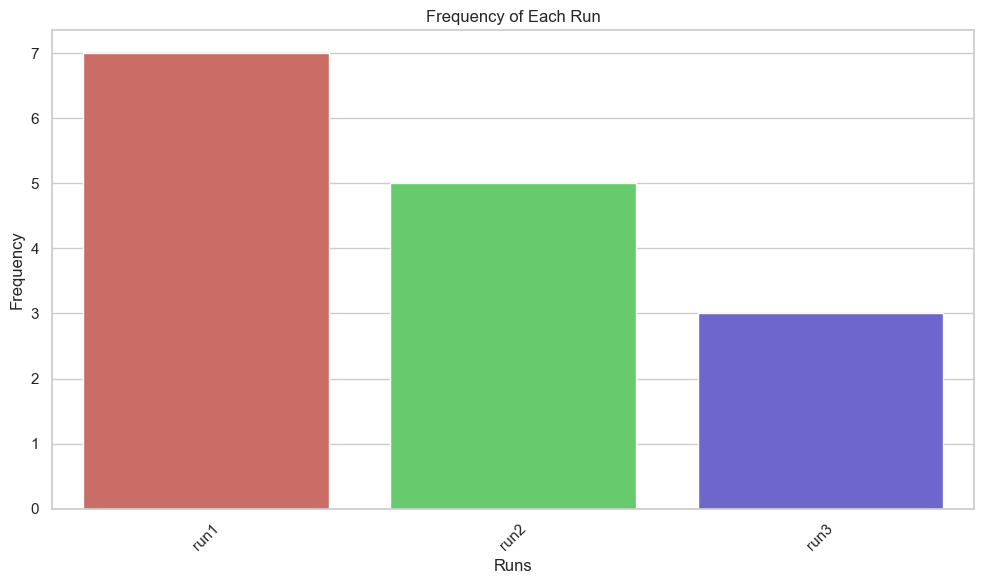

In [172]:
count_dict = {i:0 for i in histories_llama_few.index.values}

for index, row in problem_df.iterrows():
    count_dict[row["Topic"]] += 1
for key, value in count_dict.items():
    count_dict[key] = round(value/12*100, 1)


problem_df = pd.DataFrame(problem_array, columns=['Topic', 'Run'])

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='Run', data=problem_df, palette="hls")
plt.xlabel('Runs')
plt.ylabel('Frequency')
plt.title('Frequency of Each Run')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [173]:
count_dict = {i:0 for i in histories_llama_few.index.values}

for index, row in problem_df.iterrows():
    count_dict[row["Topic"]] += 1
for key, value in count_dict.items():
    count_dict[key] = round(value/12*100, 1)



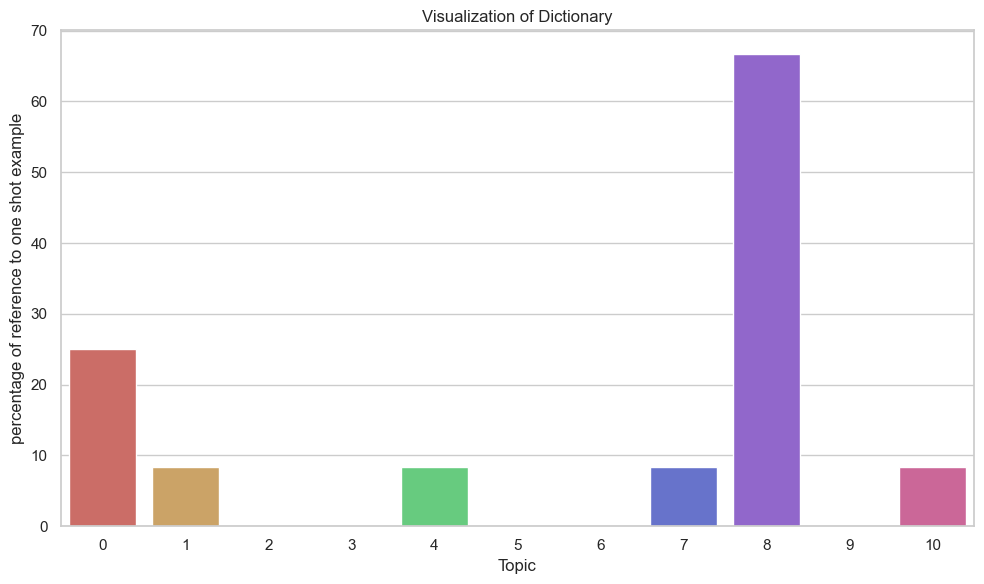

In [174]:
keys = list(count_dict.keys())
values = list(count_dict.values())



# Setting Seaborn style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("hls", len(keys))

# Creating bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=keys, y=values, palette=palette)
plt.xlabel('Topic')
plt.ylabel('percentage of reference to one shot example')
plt.title('Visualization of Dictionary')
plt.tight_layout()
plt.show()

In [20]:

with open('histories/time_llama_zero.pkl', 'rb') as f:
    time_llama_zero = pickle.load(f)


with open('histories/time_llama_few.pkl', 'rb') as f:
    time_llama_few = pickle.load(f)

In [19]:
print(f"The debate for 11 topics using zero shot learning and Llama2-Chat-7b took {sum(time_llama_zero)/60} min")

The debate for 11 topics using zero shot learning and Llama2-Chat-7b took 43.6921984910965 min


In [21]:
print(f"The debate for 11 topics using zero shot learning and Llama2-Chat-7b took {sum(time_llama_few)/60} min")

The debate for 11 topics using zero shot learning and Llama2-Chat-7b took 52.03810991843542 min


### Likert Scale (Distance Metric)

In [81]:
def create_lickert_prompt(topic, statement1, statement2):
   lickert_prompt = f'''Your task is to analyse the distance between two opinions about a topic.
   Distance in this context is defined as how much the two opinions differ in their view on a given topic. ou should rate the distance on a scale from 0 to 5.
   0: No difference
   1: Slight difference
   2: Moderate difference
   3: Significant difference
   4: Major difference
   5: Complete opposite

   First, rate the distance on a scale between 0 to 5. 
   Second, extract the key factors which name the differences in statements.

   Example topic:
   """abortion"""

   Example Statement 1:
   """
   In my view, the issue of abortion is deeply intertwined with complex moral and ethical considerations that cannot be brushed aside lightly. When we discuss birth control, it's essential to acknowledge that while it serves as a means of preventing pregnancies, it also has the inherent consequence of potentially preventing the formation of life. Whether it's through contraception or other means, we must recognize the weight of this implication.

   Furthermore, the widespread availability of free birth control can inadvertently lead to a desensitization toward the gravity of abortion. By making contraceptives easily accessible without cost, we risk trivializing the profound moral questions surrounding the termination of potential life. This casual approach can undermine the seriousness of the decision-making process involved in matters of reproductive health.

   Above all, it's crucial to affirm the sanctity and inherent value of every human life. Regardless of one's stance on abortion, this principle should serve as a guiding light. Each life is sacred and deserving of respect, and any discussion on abortion must grapple with this fundamental truth.

   In essence, the debate on abortion demands a thoughtful examination of these interconnected issues, with a recognition of the complexities involved and a commitment to upholding the dignity of every individual life.
   """


   Example Statement 2:
      
   """
   While you are correct that a potential life is being "killed",
      I would argue that every woman's right to decide what to do with her body outweighs the negative. That leads me to yours
      Argument that every life is sacred and beautiful. We need to see women becoming unintentionally and perhaps even porous
      The sexual act may not have been consensual. Let's imagine the worst case scenario, a financial weak woman is being raped and doesnt wont the child of 
      her abuser. In my opinion, the damage could be minimized by at least helping this woman with the burden of raising a child she never wanted.
      I understand where you're coming from when you argue that the topic is becoming too casual, but the impact on a woman's body is huge 
      and I don't think a woman would do this lightly several times. So I strongly disagree. Another important point for abortion in my opinion is
      that criminalizing abortion does not stop abortions, it just makes them less safe.
   """

   Example Answer:
   """
   Distance : 3
   
   Main points of difference:
   1. Moral and Ethical Considerations
   2. Individual Rights versus Sanctity of Life
   3. Approach to Addressing Abortion
  

   This was the example. Now to the actual task:

   the topic:
   """{topic}"""

   Statement1:
   """
   {statement1}"""

   Statement 2:
   """{statement2}"""


   Answer:'''
   
   return lickert_prompt

In [28]:
data.head()

,Stance_1_run1,Stance_2_run1,Stance_1_run2,Stance_2_run2,Stance_1_run3,Stance_2_run3,Stance_1_run4,Stance_2_run4,Stance_1_run5,Stance_2_run5,...,Stance_1_run96,Stance_2_run96,Stance_1_run97,Stance_2_run97,Stance_1_run98,Stance_2_run98,Stance_1_run99,Stance_2_run99,Stance_1_run100,Stance_2_run100
1,"{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...",...,"{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': 'leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': 'leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo..."
2,"{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': 'Leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...",...,"{'role': 'assistant', 'content': 'Enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""Leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'Enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo..."
3,"{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': 'leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': 'leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...",...,"{'role': 'assistant', 'content': ""Enforce_stab...","{'role': 'assistant', 'content': 'leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': ""enforce_stab...","{'role': 'assistant', 'content': ""leave_to_peo...","{'role': 'assistant', 'content': 'enforce_stab...","{'role': 'assistant', 'content': 'leave_to_peo...","{'role': 'assistant', 'content': ""Enforce_stab...","{'role': 'assistant', 'content': 'leave_to_peo..."


In [41]:
def extracting_distance(distance_prompt):
    message = [{"role": "user", "content": distance_prompt}]
    answer = openai.ChatCompletion.create(model=model_name,
                                                     temperature = 1.0,
                                         messages=message,
                                        max_tokens = 250,
                                                n = 1)
    return answer['choices'][0]['message']['content']

In [80]:
runs = 31

for topic in topics:
    filename = f"conversations/{topic}.csv"
    data = pd.read_csv(filename).drop(columns="Unnamed: 0")
    data = data.loc[1:, :]


    distances = pd.DataFrame()
    for run in tqdm(range(1,runs)):
        for index, row in data.iterrows():
            stance1 = row[f"Stance_1_run{run}"].split("\'content\': ")[1][1:-2]
            stance2 = row[f"Stance_2_run{run}"].split("\'content\': ")[1][1:-2]
            distance_prompt = create_lickert_prompt(topic, stance1, stance2)
            distances.loc[index, run] = extracting_distance(distance_prompt)
       
    writeto = f"distances/{topic}_distances.csv"
    distances.to_csv(writeto)
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:59<00:00,  5.97s/it]


### Transforming Llama zeroshot data into correct format

In [101]:
histories_llama_zero = pd.read_csv("histories/histories_llama_zero.csv")

In [175]:
histories_llama_zero.head()

,Unnamed: 0,run1,run2,run3
0,0,"[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task..."
1,1,"[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task..."
2,2,"[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task..."
3,3,"[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task..."
4,4,"[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task...","[{'role': 'system', 'content': '\n The task..."


In [169]:

for index, row in histories_llama_zero.iterrows():
    conversations = pd.DataFrame()
    for i in range(1,4):
        # round of debate 
        round = 1
        for idx in [3,5,7,9]: 
            current = row[f"run{i}"].split("{")[idx].split("\'content\': ")[1][1:-4].strip()
            if idx in [3,7]:
                column_name = f"Stance_1_run{i}"
                conversations.loc[round, column_name] = current

            else:
                column_name = f"Stance_2_run{i}"
                conversations.loc[round, column_name] = current
                round += 1
            

    
    writeto = f"conversations/Llama/{topics[index]}.csv"
    conversations.to_csv(writeto)

    


                
            

In [174]:
# in here we create the distances for Llama2_Chat_7b responses

for topic in topics:
    filename = f"conversations/Llama/{topic}.csv"
    data = pd.read_csv(filename).drop(columns="Unnamed: 0")


    distances = pd.DataFrame()
    for run in tqdm(range(1,4)):
        for index, row in data.iterrows():
            stance1 = row[f"Stance_1_run{run}"]
            stance2 = row[f"Stance_2_run{run}"]
            distance_prompt = create_lickert_prompt(topic, stance1, stance2)
            distances.loc[index, run] = extracting_distance(distance_prompt)
       
    writeto = f"distances/Llama/{topic}_distances.csv"
    distances.to_csv(writeto)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.69s/it]


## Analysing Results

### GPT

In [69]:
high_agreement = []
high_agreement_reasons = []
low_agreement_reasons = []
low_agreement = []

for topic in topics:
    distances = pd.read_csv(f"distances/GPT/{topic}_distances.csv").drop(columns="Unnamed: 0")
    conversations = pd.read_csv(f"conversations/GPT/{topic}.csv")[1:]
    for index, row in distances.iterrows():
        for i in range(1,runs):
            current_debate = row[f"{i}"]
            distance = int(re.findall(r"^.*[0-5]{1}", current_debate)[0][-1])
            if distance == 0:
                # uncomment for manual analysis
                print(current_debate)
                print(conversations.loc[index+1,f"Stance_1_run{i}"])
                print(conversations.loc[index+1,f"Stance_2_run{i}"])
                high_agreement.append((topic, index))
            elif distance == 5:
                low_agreement_reasons.append(current_debate)

                low_agreement.append((topic, index))


Distance: 0

Main points of agreement:
1. Leveraging technological advancements
2. Transitioning towards sustainability
3. Importance of collaboration and dialogue

Overall, both statements show a strong alignment in their views on addressing climate change through technology and sustainability, emphasizing the need for collaboration and dialogue in achieving a more environmentally conscious future.
{'role': 'assistant', 'content': 'pro_techno: \n\npost_growth, I appreciate your thoughtful insights on the need to address the systemic issues associated with perpetual economic growth while leveraging technological advancements to combat climate change. Here are my responses to your points:\n\n1. I agree that simply relying on technological solutions within a growth-driven economic system may not be sufficient to achieve long-term sustainability. It is crucial to couple technological innovations with structural changes that prioritize environmental well-being and social equity. This requi

In [35]:
message = [{"role": "user", "content": prompt}]
answer = openai.ChatCompletion.create(model=model_name,
                                                     temperature = 1.0,
                                         messages=message,
                                        max_tokens = 1000,
                                                n = 1)

In [36]:
answer['choices'][0]['message']['content']

'The main recurring points of difference across the debates include:\n1. Approaches to combating climate change (technological solutions vs. reducing economic growth)\n2. Perspectives on gun control measures (upholding Second Amendment vs. implementing strict control)\n3. Views on taxation policies (low-tax environment for growth vs. higher taxes for social welfare)\n4. Beliefs on the balance between national security and individual privacy\n5. Perspectives on the role of government in regulating markets\n6. Debates on embracing change versus preserving tradition in societal values.'

In [403]:
print(f"there are {len(high_agreement)} debate rounds of high agreement and {len(low_agreement)} of high disagremement.")

there are 26 debate rounds of high agreement and 93 of high disagremement.


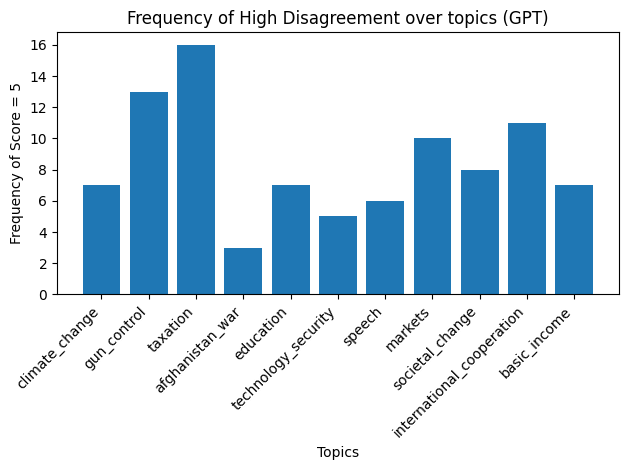

In [394]:



# Count the frequency of each term (first element in the tuple)
term_counts = Counter(term for term, _ in low_agreement)

# Extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

# Create the bar chart
plt.bar(terms, frequencies)
plt.xlabel("Topics")
plt.ylabel("Frequency of Score = 5")
plt.title("Frequency of High Disagreement over topics (GPT)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Show the chart
plt.tight_layout()
plt.show()

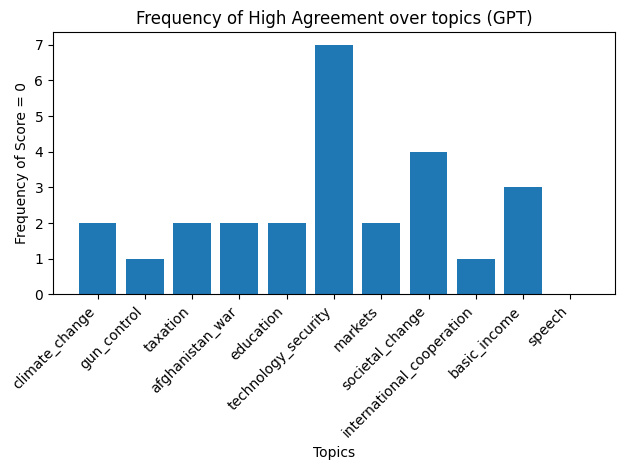

In [395]:
# count the frequency of each term (first element in the tuple)
term_counts = Counter(term for term, _ in high_agreement)
# speech does not appear in the analysis therefore set freq to 0
term_counts["speech"] = 0
# extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

plt.bar(terms, frequencies)
plt.xlabel("Topics")
plt.ylabel("Frequency of Score = 0")
plt.title("Frequency of High Agreement over topics (GPT)")
plt.xticks(rotation=45, ha="right")  

# Show the chart
plt.tight_layout()
plt.show()

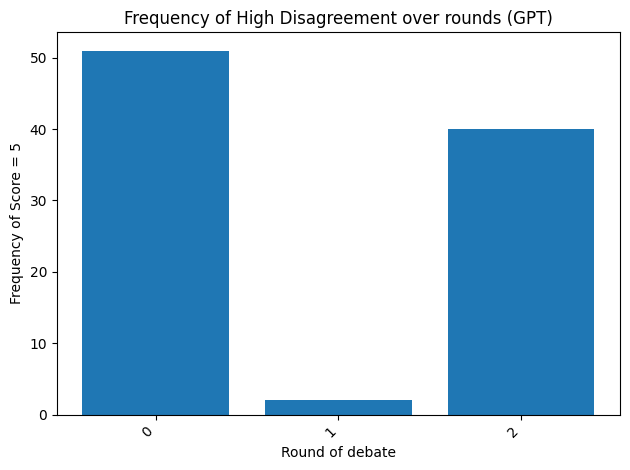

In [396]:
# count the frequency of each term (first element in the tuple)
term_counts = Counter(round for _, round in low_agreement)

# extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

plt.bar(terms, frequencies)
plt.xlabel("Round of debate")
plt.ylabel("Frequency of Score = 5")
plt.title("Frequency of High Disagreement over rounds (GPT)")
plt.xticks(rotation=45, ha="right", ticks=[0,1,2])  # Rotate x-axis labels for better readability

# Show the chart
plt.tight_layout()
plt.show()

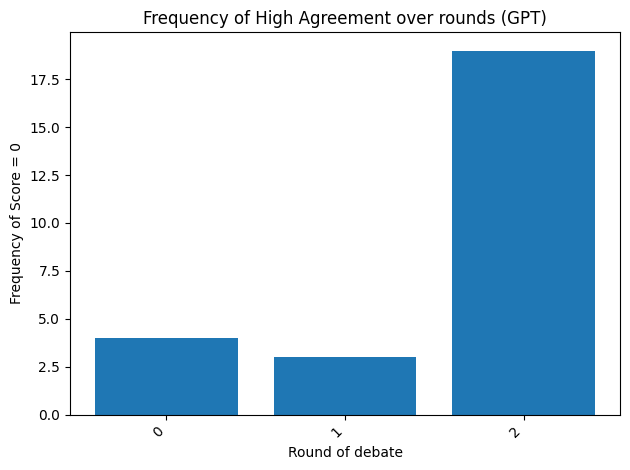

In [397]:
# Count the frequency of each term (first element in the tuple)
term_counts = Counter(round for _, round in high_agreement)

# Extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

# Create the bar chart
plt.bar(terms, frequencies)
plt.xlabel("Round of debate")
plt.ylabel("Frequency of Score = 0")
plt.title("Frequency of High Agreement over rounds (GPT)")
plt.xticks(rotation=45, ha="right", ticks=[0,1,2]) 

# Show the chart
plt.tight_layout()
plt.show()

In [384]:
converge = []
diverge = []
stable = []

for topic in topics:
    distances = pd.read_csv(f"distances/GPT/{topic}_distances.csv").drop(columns="Unnamed: 0")
    conversations = pd.read_csv(f"conversations/GPT/{topic}.csv")[1:]
    for i in range(1,runs):

        for index, row in distances.iterrows():
                current_debate = row[f"{i}"]
                distance = int(re.findall(r"^.*[0-5]{1}", current_debate)[0][-1])
                if index == 0:
                    start_distance = distance
                if index == 2:
                    end_distance = distance
        if start_distance > end_distance:
            converge.append((topic, index, start_distance-end_distance))
        elif start_distance < end_distance:
            diverge.append((topic, index, start_distance-end_distance))
        else:
            stable.append((topic, index))

           






In [385]:
print(f"For the GPT model {len(stable)} runs were stable, {len(diverge)} runs diverged and {len(converge)} converged")

For the GPT model 74 runs were stable, 53 runs diverged and 203 converged


In [386]:
distance_changes = [distance_change for _,_, distance_change in converge]

# calculate the average using sum and division
average_convergence = sum(distance_changes) / len(distance_changes)
print(average_convergence)

1.9507389162561577


In [387]:
distance_changes = [distance_change for _,_, distance_change in diverge]

# calculate the average using sum and division
average_diverge = sum(distance_changes) / len(distance_changes)
print(average_diverge)

-1.5471698113207548


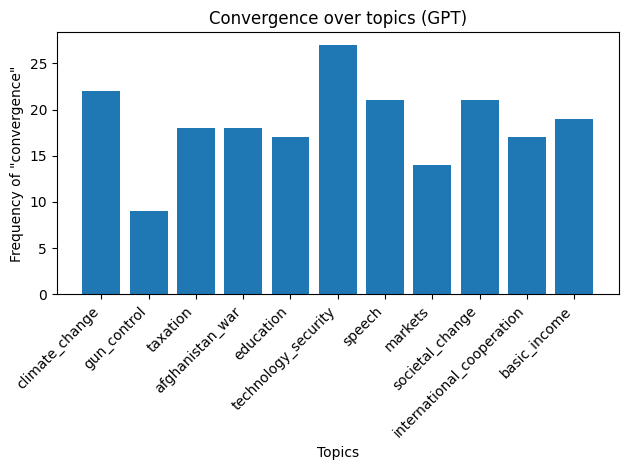

In [388]:
# Count the frequency of each term (first element in the tuple)
term_counts = Counter(topic for topic,_,_ in converge)

# Extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

# Create the bar chart
plt.bar(terms, frequencies)
plt.xlabel("Topics")
plt.ylabel("Frequency of \"convergence\"")
plt.title("Convergence over topics (GPT)")
plt.xticks(rotation=45, ha="right") 

# Show the chart
plt.tight_layout()
plt.show()

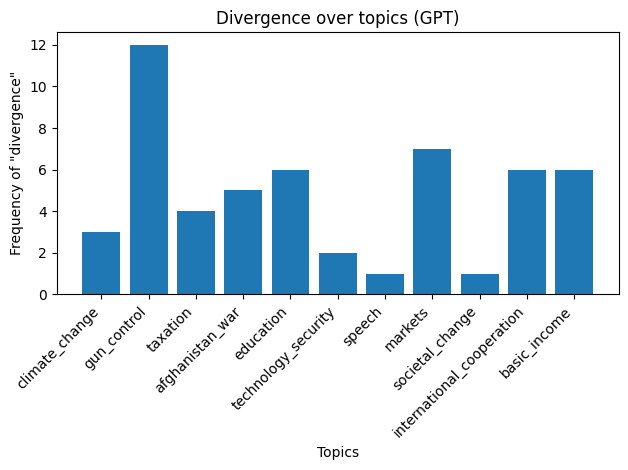

In [389]:
# Count the frequency of each term (first element in the tuple)
term_counts = Counter(topic for topic,_,_ in diverge)

# Extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

# Create the bar chart
plt.bar(terms, frequencies)
plt.xlabel("Topics")
plt.ylabel("Frequency of \"divergence\"")
plt.title("Divergence over topics (GPT)")
plt.xticks(rotation=45, ha="right") 

# Show the chart
plt.tight_layout()
plt.show()

In [4]:
intial_distances = []
for topic in topics:
    distances = pd.read_csv(f"distances/GPT/{topic}_distances.csv").drop(columns="Unnamed: 0")
    conversations = pd.read_csv(f"conversations/GPT/{topic}.csv")[1:]
    for i in range(1,runs):
        for index, row in distances.iterrows():
                current_debate = row[f"{i}"]
                distance = int(re.findall(r"^.*[0-5]{1}", current_debate)[0][-1])
                if index == 0:
                    intial_distances.append((topic, distance))


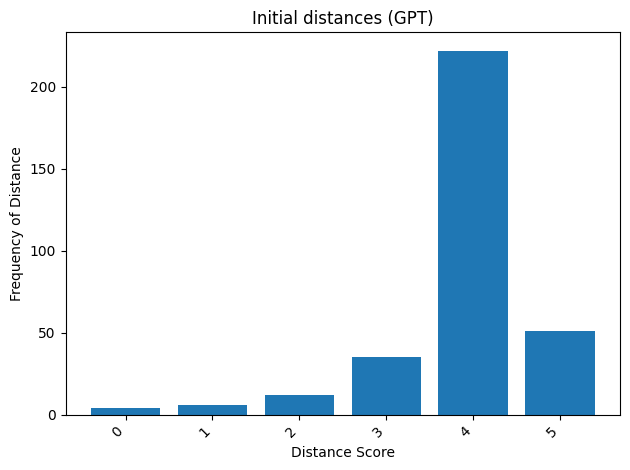

In [5]:
# Count the frequency of each term (first element in the tuple)
term_counts = Counter(distance for _,distance in intial_distances)

# Extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

# Create the bar chart
plt.bar(terms, frequencies)
plt.xlabel("Distance Score")
plt.ylabel("Frequency of Distance")
plt.title("Initial distances (GPT)")
plt.xticks(rotation=45, ha="right") 

# Show the chart
plt.tight_layout()
plt.show()

In [8]:
print(term_counts[3]+term_counts[4]+term_counts[5])

308


In [10]:
print(term_counts)

Counter({4: 222, 5: 51, 3: 35, 2: 12, 1: 6, 0: 4})


### Llama2-Chat-7b

In [326]:
converge = []
diverge = []
stable = []

for topic in topics:
    distances = pd.read_csv(f"distances/Llama/{topic}_distances.csv").drop(columns="Unnamed: 0")
    conversations = pd.read_csv(f"conversations/Llama/{topic}.csv")
    for i in range(1,4):

        for index, row in distances.iterrows():
                current_debate = row[f"{i}"]
                distance = int(re.findall(r"^.*[0-5]{1}", current_debate)[0][-1])
                if index == 0:
                    start_distance = distance
                if index == 2:
                    end_distance = distance
        if start_distance > end_distance:
            converge.append((topic, index, start_distance-end_distance))
        elif start_distance < end_distance:
            diverge.append((topic, index, start_distance-end_distance))
        else:
            stable.append((topic, index))

In [327]:
print(f"For Llama2-Chat-7b {len(stable)} runs were stable, {len(diverge)} runs diverged and {len(converge)} converged")

For Llama2-Chat-7b 0 runs were stable, 0 runs diverged and 33 converged


In [328]:
distance_changes = [distance_change for _,_, distance_change in converge]

# calculate the average using sum and division
average_convergence = sum(distance_changes) / len(distance_changes)
print(average_convergence)

1.9696969696969697


In [378]:
high_agreement = []
low_agreement = []

for topic in topics:
    distances = pd.read_csv(f"distances/Llama/{topic}_distances.csv").drop(columns="Unnamed: 0")
    conversations = pd.read_csv(f"conversations/Llama/{topic}.csv")
    for index, row in distances.iterrows():
        for i in range(1,4):
            current_debate = row[f"{i}"]
            distance = int(re.findall(r"^.*[0-5]{1}", current_debate)[0][-1])
            if distance == 0:
                # uncomment for manual analysis
                #print(current_debate)
                #print(conversations.loc[index+1,f"Stance_1_run{i}"])
                #print(conversations.loc[index+1,f"Stance_2_run{i}"])
                high_agreement.append((topic, index))
            elif distance == 5:
                low_agreement.append((topic, index))

In [379]:



# Count the frequency of each term (first element in the tuple)
term_counts = Counter(term for term, _ in low_agreement)

# Extract terms and their frequencies
terms = list(term_counts.keys())



In [380]:
missing = [topic for topic in topics if topic not in terms]
for topic in missing:
    term_counts[topic] = 0

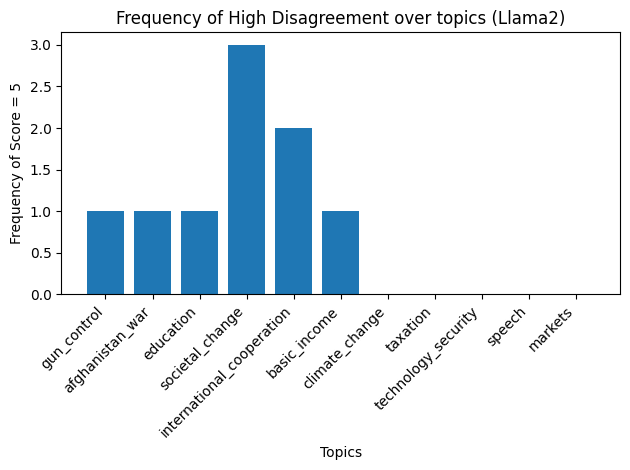

In [381]:
terms = list(term_counts.keys())

frequencies = list(term_counts.values())

# Create the bar chart
plt.bar(terms, frequencies)
plt.xlabel("Topics")
plt.ylabel("Frequency of Score = 5")
plt.title("Frequency of High Disagreement over topics (Llama2)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Show the chart
plt.tight_layout()
plt.show()

In [368]:
print(high_agreement)

[('gun_control', 1)]


In [370]:
len(low_agreement)

9

In [373]:
intial_distances = []

for topic in topics:
    distances = pd.read_csv(f"distances/Llama/{topic}_distances.csv").drop(columns="Unnamed: 0")
    conversations = pd.read_csv(f"conversations/Llama/{topic}.csv")
    for i in range(1,4):
        for index, row in distances.iterrows():
                current_debate = row[f"{i}"]
                distance = int(re.findall(r"^.*[0-5]{1}", current_debate)[0][-1])
                if index == 0:
                    intial_distances.append((topic, distance))


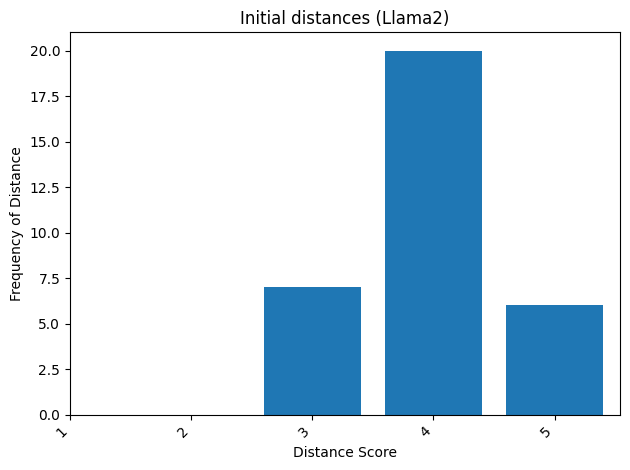

In [376]:
# Count the frequency of each term (first element in the tuple)
term_counts = Counter(distance for _,distance in intial_distances)

# Extract terms and their frequencies
terms = list(term_counts.keys())
frequencies = list(term_counts.values())

# Create the bar chart
plt.bar(terms, frequencies)
plt.xlabel("Distance Score")
plt.ylabel("Frequency of Distance")
plt.title("Initial distances (Llama2)")
plt.xticks(rotation=45, ha="right", ticks = [1,2,3,4,5]) 

# Show the chart
plt.tight_layout()
plt.show()